In [ ]:
pip install tensorflow

In [ ]:
pip install numpy

In [ ]:
pip install pillow

In [ ]:
pip install keras

In [ ]:
pip install matplotlib

In [6]:
# All import statements
import tensorflow as tf
import keras
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt
from numpy import unique, argmax
from keras.datasets.mnist import load_data
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense
from keras.layers import Flatten, Dropout
from keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

# Just checking the version
# Because a lot of compatibility issues
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.14.0
Keras version: 2.14.0
NumPy version: 1.23.5


In [7]:
# function to load the extended MNIST Dataset
def load_idx_data(image_path, label_path):
    with gzip.open(label_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(image_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28, 1)

    return images, labels

In [8]:
# LOADING and PREPROCESSING the MNIST datasets

# We load the Standard MNIST dataset
# spliting the dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Reshaping the training and testing data
# We are reshaphing the MNIST dataset to greyscale
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# Normalizing the values of the pixels of the images
# We do this so all pixels values of each image in the dataset are unsigned integers in the range of 0 to 255
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Loading the extended MNIST dataset
train_images, train_labels = load_idx_data('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_images, test_labels = load_idx_data('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [9]:
# Expanding the Dataset little more
# Augmenting the Dataset by shifting the position of the images

# Function to Augument the Dataset

def augment_dataset(x,y):
  # Utilize the ImageDataGenerator to shift the image
  shift = 1.0 /28 # because the images are 28x28 pixels
  datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

  # Initializing empty arrays to store the augmented images and labels
  augmented_images = []
  augmented_labels = []

  # Augment all the images in the dataset
  for i in range(len(x)):
    # Reshaping the image
    image = x[i].reshape((1,)+ x[i].shape)

    # Apply four shifts to each image (up, down, left, right)
    for shift in ['right', 'left', 'up', 'down']:
        # Configure the datagen for the specific shift
        if shift == 'right':
            datagen.width_shift_range = -1.0 / 28
            datagen.height_shift_range = 0
        elif shift == 'left':
            datagen.width_shift_range = 1.0 / 28
            datagen.height_shift_range = 0
        elif shift == 'up':
            datagen.width_shift_range = 0
            datagen.height_shift_range = 1.0 / 28
        elif shift == 'down':
            datagen.width_shift_range = 0
            datagen.height_shift_range = -1.0 / 28

        # Generate augmented images (just one in this case)
        for x_aug in datagen.flow(image, batch_size=1):
            augmented_images.append(x_aug[0])
            augmented_labels.append(y[i])
            break  # we only want to augment the image once per shift

  # Convert the lists to numpy arrays
  augmented_images = np.array(augmented_images)
  augmented_labels = np.array(augmented_labels)

  return augmented_images, augmented_labels


In [10]:
augmented_x_train, augmented_y_train = augment_dataset(x_train, y_train)
augmented_x_test, augmented_y_test = augment_dataset(x_test, y_test)

In [11]:
# Combining the Training data
x_train_combined = np.concatenate((x_train, augmented_x_train))
y_train_combined = np.concatenate((y_train, augmented_y_train))

# Combining the Testing Data
x_test_combined = np.concatenate((x_test, augmented_x_test))
y_test_combined = np.concatenate((y_test, augmented_y_test))

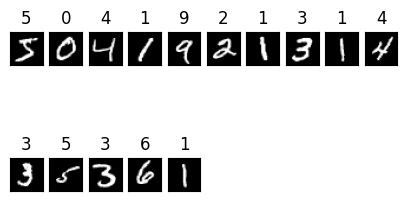

In [12]:
fig = plt.figure(figsize=(5,3))
for i in range(15):
  ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_train[i]), cmap='gray')
  ax.set_title(y_train_combined[i])

In [13]:
# Checking the shape of the input images
# 28x28 pixels grayscales
img_shape = x_train_combined.shape[1:]
print(img_shape)

(28, 28, 1)


In [14]:
# Defining the CNN model we are going to use
# Sequential
model = Sequential()

# Adding the Convolutional Layer
# Using the Rectified Linear Unit activation function
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization()) # To stabalize and speed up the training process
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))


model.add(Flatten())
# Network layer has 1024 nodes
model.add(Dense(1024, activation='relu'))
# Dropping 50% of the weights
model.add(Dropout(0.5))
# Output layer has just 10 nodes
model.add(Dense(10, activation='softmax'))

In [15]:
# Checking the model Summary
# Understanding the build
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
# How the model looks
# Looking at the Layers
plot_model(model, 'model.jpg', show_shapes=True)

In [17]:
# Now comes the tricky part
# Training the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_combined, y_train_combined, epochs=10, batch_size=128, verbose=2, validation_split=0.1)

Epoch 1/10
2110/2110 - 1020s - loss: 0.0713 - accuracy: 0.9781 - val_loss: 0.0363 - val_accuracy: 0.9891 - 1020s/epoch - 483ms/step
Epoch 2/10
2110/2110 - 995s - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.0426 - val_accuracy: 0.9886 - 995s/epoch - 472ms/step
Epoch 3/10
2110/2110 - 983s - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0317 - val_accuracy: 0.9920 - 983s/epoch - 466ms/step
Epoch 4/10
2110/2110 - 943s - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0331 - val_accuracy: 0.9901 - 943s/epoch - 447ms/step
Epoch 5/10
2110/2110 - 961s - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0402 - val_accuracy: 0.9915 - 961s/epoch - 455ms/step
Epoch 6/10
2110/2110 - 985s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.0321 - val_accuracy: 0.9930 - 985s/epoch - 467ms/step
Epoch 7/10
2110/2110 - 986s - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.0271 - val_accuracy: 0.9940 - 986s/epoch - 467ms/step
Epoch 8/10
2110/2110 - 976s - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0242 - val_a

In [18]:
loss, accuracy = model.evaluate(x_test_combined, y_test_combined, verbose=0)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 99.02399778366089%


1/1 [==============================] - 0s 90ms/step


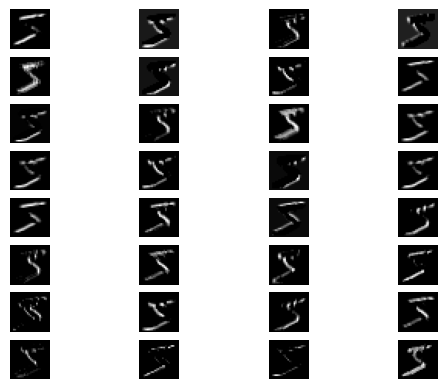

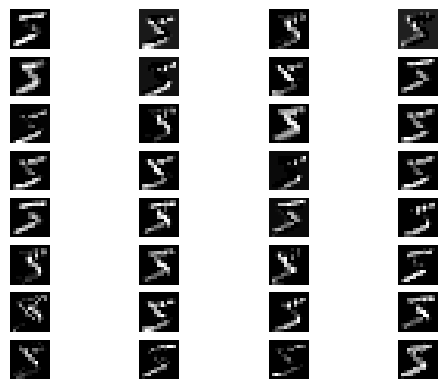

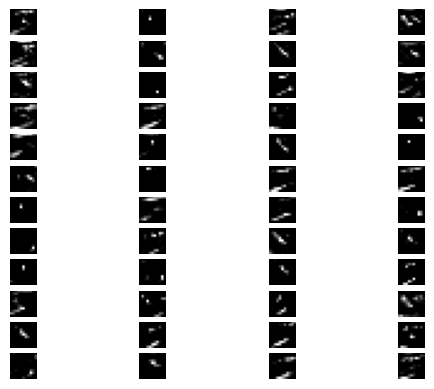

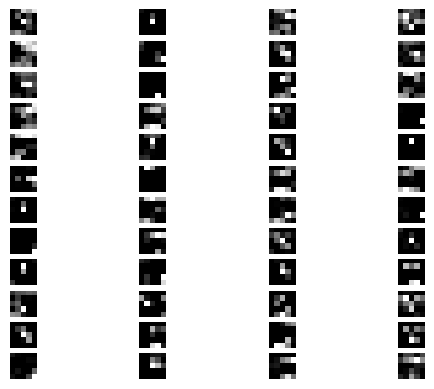

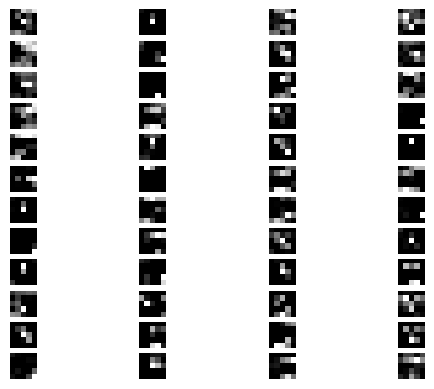

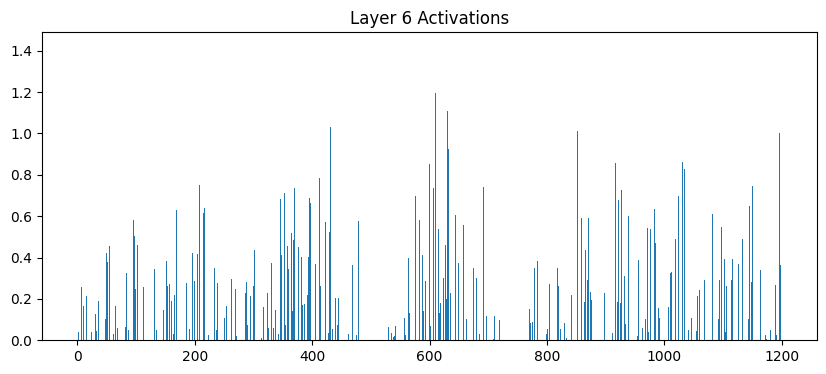

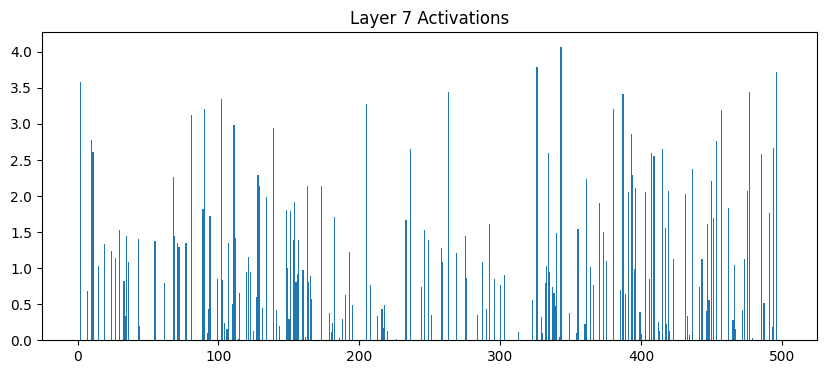

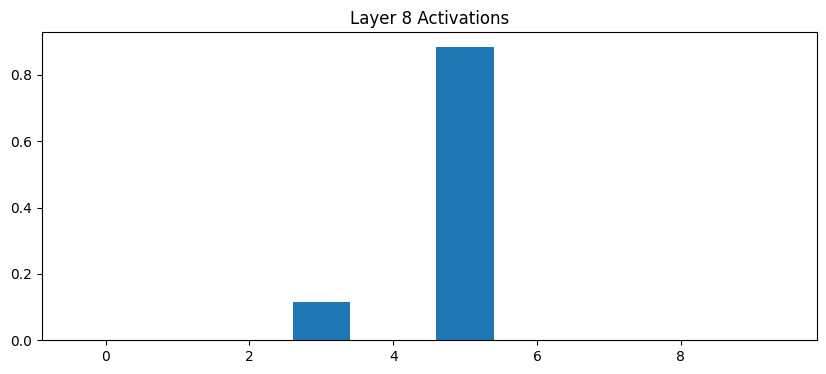

In [33]:
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import argmax
# To extract and display intermediate layer outputs

model = model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


def display_layer_activations(layer_activations, image):
    activation_values = activation_model.predict(image)
    #max_channels_to_display = 32
    for i, activation_value in enumerate(activation_values):
      if len (activation_value.shape) ==4:
        channels = activation_value.shape[-1]
        rows = channels // 4
        cols =4
       # channels = min(channels, max_channels_to_display)
        #cols = 8
        #rows = channels // cols + (channels % cols > 0)  # Display up to 4 channels per row
        #plt.figure(figsize=(cols *2, rows *2))
        for j in range(channels):
            ax = plt.subplot(rows, cols, j + 1)
            ax.imshow(activation_value[0, :, :, j], cmap='gray')  # Use 'gray' colormap for greyscale
            ax.axis('off')
        plt.show()
      elif len(activation_value.shape) == 2:
            # This is for Dense Layers
            # Example: Just plot the activation values as a bar chart
          plt.figure(figsize=(10, 4))
          plt.bar(range(len(activation_value[0])), activation_value[0])
          plt.title(f"Layer {i+1} Activations")
          plt.show()

# Display intermediate layer activations for a sample image (e.g., the first image in the training set)
sample_image = x_train[0].reshape(1, 28, 28, 1)
display_layer_activations(layer_outputs, sample_image)

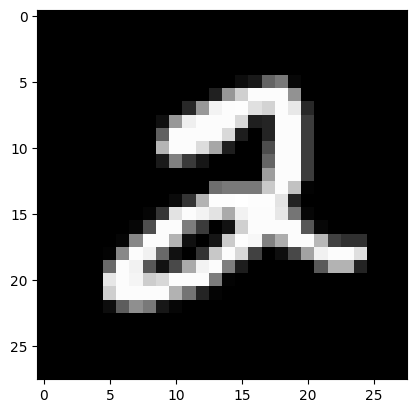

In [28]:
# Time to validate our prediction
# We first display the Image we want to validate our prediction on
# image = x_train[10]
image = x_train_combined[5]
plt.imshow(np.squeeze(image), cmap='gray')
plt.show()

In [29]:
# now we check if the predicted label and the image is correct or not
image= image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
prediction = model.predict([image])
print('Image Prediction: {}'.format(argmax(prediction)))

1/1 [==============================] - 0s 24ms/step
Image Prediction: 2


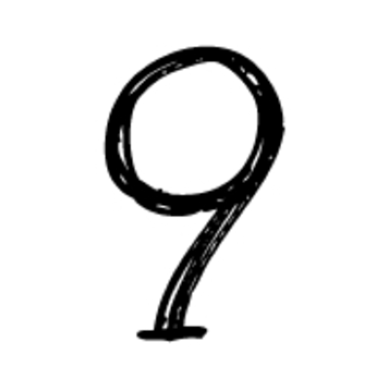

1/1 [==============================] - 0s 22ms/step
Model Prediction: 0


In [30]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess the user-uploaded image
def preprocess_user_image(image_path, target_size=(28, 28)):
    # Open the image file
    user_image = Image.open(image_path).convert('L')  # Convert to grayscale
    # Resize the image to the target size
    user_image = user_image.resize(target_size)
    # Convert the image to a NumPy array
    user_image_array = np.array(user_image)
    # Reshape the array to match the model's input shape
    user_image_array = user_image_array.reshape(1, target_size[0], target_size[1], 1)
    # Normalize pixel values to be in the range [0, 1]
    user_image_array = user_image_array.astype('float32') / 255.0

    return user_image_array

# Function to display the user-uploaded image
def display_user_image(image_path):
    user_image = Image.open(image_path).convert('L')
    plt.imshow(user_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Get the path to the user-uploaded image
#user_image_path = input("Enter the path to your handwritten image file: ")
user_image_path = "new9.jpg"

# Display the user-uploaded image
display_user_image(user_image_path)

# Preprocess the user-uploaded image
preprocessed_user_image = preprocess_user_image(user_image_path)

# Make predictions using the trained model
predictions = model.predict(preprocessed_user_image)

# Display the model's prediction
predicted_digit = np.argmax(predictions)
print(f'Model Prediction: {predicted_digit}')
